In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [86]:
data = pd.read_csv('../../01_exploratory_data_analysis/rainfall/dataset_rainfall.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.sample(15)

ISO3_code  Year  pt_gdp_agriculture   oil_rent  democracy_polity  \
4801       LKA  2009           12.691972   0.000000          5.000000   
5200       MDG  2023           22.637420   0.000000          1.322034   
8157       TUN  1970           17.032822   2.038174         -9.000000   
8500       URY  1992            8.815643   0.000000         10.000000   
915        BGR  1976           20.476843   0.005028         -7.000000   
392        AUS  1965            4.193446   0.015371         10.000000   
7023       SDN  1988           39.372880   0.000000         -4.000000   
5300       MLI  1995           37.708954   0.000000          4.000000   
1372       CAN  1985            2.196213   2.357283         10.000000   
6017       NOR  2008            1.082553   9.873526         10.000000   
1981       CYP  2018            1.718138   0.000000         10.000000   
4460       KWT  1991            0.537729  13.217576         -9.000000   
722        BEN  1975           30.538666   0.000000         -7.000000   
7546       SVN  1999            2.935543   0.000037         10.000000   
2874       GBR  2015            0.631167   0.240246         10.000000   

               gdp         country  ethnic_fractionation_index  \
4801  5.788830e+10       Sri Lanka                       0.331   
5200  1.397761e+10      Madagascar                       0.194   
8157  6.092069e+09         Tunisia                       0.079   
8500  2.886501e+10         Uruguay                       0.188   
915   2.907017e+10        Bulgaria                       0.259   
392   2.557204e+11       Australia                       0.027   
7023  1.986546e+10           Sudan                       0.747   
5300  4.906876e+09            Mali                       0.853   
1372  7.714296e+11          Canada                       0.703   
6017  3.601679e+11          Norway                       0.127   
1981  2.384550e+10          Cyprus                       0.347   
4460  2.001817e+10          Kuwait                       0.753   
722   2.359974e+09           Benin                       0.785   
7546  3.102809e+10        Slovenia                       0.221   
2874  2.927911e+12  United Kingdom                       0.399   

      yearly_avg_rainfall  rainfall_var_t  rainfall_var_t_1  yearly_avg_temp  \
4801          1213.192982       -0.226855          0.244868       275.618421   
5200          1241.883578        0.030604          0.044284       231.088644   
8157           191.995833       -0.444673          0.712253       190.897222   
8500          1141.388060        0.012354         -0.117225       177.560945   
915            538.355442       -0.116650          0.291718        98.173469   
392            306.441169       -0.208370         -0.077440       217.993470   
7023           233.101084        0.551149         -0.066877       272.525881   
5300           241.051190       -0.208485          0.350964       288.950992   
1372           376.183031       -0.053681          0.022315       -72.119568   
6017           729.989184       -0.030547          0.030952        -2.501229   
1981           472.750000        0.569729         -0.167984       203.000000   
4460           137.819444        1.141809         -0.187621       254.250000   
722            897.758333        0.029537          0.194711       270.468750   
7546          1044.883333        0.008510          0.157153        96.625000   
2874           972.750579       -0.069532          0.204671        89.304398   

      temp_var_t  temp_var_t_1  
4801    0.013744     -0.002077  
5200    0.017739     -0.006937  
8157    0.018707     -0.025496  
8500   -0.031308      0.029191  
915    -0.116975      0.038705  
392     0.020916     -0.003598  
7023   -0.011715      0.006447  
5300    0.016112     -0.022060  
1372    0.022850     -0.021838  
6017    1.077803     -3.196949  
1981    0.048644     -0.020795  
4460   -0.018866      0.024489  
722    -0.003737     -0.027682  
7546    0.000173      0.054197  
287

In [82]:
import sys
sys.path.insert(0, '.')
sys.path.insert(1, '../../01_exploratory_data_analysis/rainfall')

from utils import diff

### Add features

- GDP variation (`gdp_g`)
- Rainfall difference from all-time average (`rainfall_diff_from_mean_norm`)
- Number of years in a row we are below average (`n_below_rainfall`)
- (Categorical variable) whether oil rent average over years is above 20% (`oil_prod`)
- (Categorical variable) whether % GDP due to agriculture average over years is above 40% (`agricultural`)

In [87]:
gdp_g = pd.DataFrame()
for country in data['ISO3_code'].unique():
    gdp = data[data['ISO3_code']==country].gdp
    gdp_diff = diff(gdp)
    gdp_diff = np.concatenate(([gdp_diff[0]], gdp_diff))
    gdp_diff[np.where(gdp_diff > 1)] = 0

    years = data[data['ISO3_code']==country].Year
    mean_rainfall = data[data['ISO3_code']==country].yearly_avg_rainfall.mean()
    avg_rainfall = data[data['ISO3_code']==country].yearly_avg_rainfall

    n_below = []
    prev = 0
    for i, yr in enumerate(years):
        if avg_rainfall.to_list()[i] < mean_rainfall:
            prev += 1
        else:
            prev = 0
        n_below.append(prev)

    mean_oil = data[data['ISO3_code']==country].oil_rent.mean()
    mean_agr = data[data['ISO3_code']==country].pt_gdp_agriculture.mean()

    to_add = pd.DataFrame({'ISO3_code': [country]*len(gdp_diff),
                           'Year': years,
                           'gdp_g': gdp_diff,
                           'rainfall_diff_from_mean_norm': (avg_rainfall - mean_rainfall)/mean_rainfall,
                           'n_below_rainfall': n_below,
                           'oil_prod': [mean_oil >= 20] * len(gdp_diff),
                           'agricultural': [mean_agr >= 40] * len(gdp_diff),
                           'low_oil_high_agr': [(mean_oil < 20) & (mean_agr >= 40)] * len(gdp_diff)
                          })
    gdp_g = pd.concat([gdp_g, to_add])

data = data.merge(gdp_g, on=['ISO3_code', 'Year'])

data.sample(15)

ISO3_code  Year  pt_gdp_agriculture  oil_rent  democracy_polity  \
1021       BLR  2010            8.891520  0.772806              -7.0   
2443       ESP  1960            4.379625  0.000151              -7.0   
1001       BLR  1990           22.863740  1.445972               0.0   
4981       LTU  2018            2.886857  0.026790              10.0   
6827       ROU  2005            8.486104  1.197017               9.0   
1633       COD  1982           56.544018  0.293930              -9.0   
6153       NZL  1974            8.239367  0.083194              10.0   
5948       NLD  1961            5.635064  0.003729              10.0   
1675       COG  1960           23.600464  0.003098               3.0   
7773       TCD  1988           35.190420  0.000000              -7.0   
4934       LTU  1971           10.880504  0.008444              -7.0   
7584       SVN  1991            3.828298  0.000014              10.0   
4902       LSO  2003            6.346886  0.000000               8.0   
3276       GTM  1961           28.733763  0.000000              -5.0   
4099       JOR  2000            2.015437  0.003825              -2.0   

               gdp                       country  ethnic_fractionation_index  \
1021  5.326223e+10                       Belarus                       0.316   
2443  1.914052e+11                         Spain                       0.438   
1001  2.943518e+10                       Belarus                       0.363   
4981  4.681254e+10                     Lithuania                       0.346   
6827  1.349129e+11                       Romania                       0.202   
1633  2.744077e+10  Democratic Republic of Congo                       0.760   
6153  7.361361e+10                   New Zealand                       0.228   
5948  1.655505e+11                   Netherlands                       0.014   
1675  1.260529e+09                         Congo                       0.700   
7773  2.488767e+09                          Chad                       0.849   
4934  1.730084e+10                     Lithuania                       0.346   
7584  2.478476e+10                      Slovenia                       0.202   
4902  1.585150e+09                       Lesotho                       0.302   
3276  7.987393e+09                     Guatemala                       0.597   
4099  1.838067e+10                        Jordan                       0.039   

      yearly_avg_rainfall  rainfall_var_t  rainfall_var_t_1  yearly_avg_temp  \
1021           607.011161       -0.113575          0.198512        67.487351   
2443           776.772727       -0.242782         -0.242782       127.458533   
1001           605.129464        0.065476          0.072132        76.762649   
4981           480.265766       -0.302382          0.102636        79.783784   
6827           636.409848        0.062557          0.360936        91.304545   
1633          1298.374062        0.048116         -0.018414       241.206181   
6153          1336.512213        0.140758         -0.119493       106.505029   
5948           744.525000        0.006121          0.006121        98.395833   
1675          1465.355797        0.040327          0.040327       246.905797   
7773           333.153922        0.592395         -0.085593       269.745294   
4934           446.182432       -0.273329          0.299626        64.434685   
7584          1009.908333        0.020737          0.055595        86.591667   
4902           554.537879       -0.170681         -0.187278       122.742424   
3276          2146.226496        0.027900          0.027900       228.585470   
4099            86.919192        0.642097         -0.292121       189.232323   

      temp_var_t  temp_var_t_1     gdp_g  rainfall_diff_from_mean_norm  \
1021   -0.056357     -0.107123  0.077500                      0.136985   
2443    0.062002      0.062002  0.118387                      0.408853   
1001   -0.045218      0.255213  0.531560                      0.1334

In [88]:
subset = data[['ISO3_code',
               'Year',
               'yearly_avg_rainfall',
               'pt_gdp_agriculture',
               'gdp',
               'gdp_g',
               'oil_rent',
               'rainfall_diff_from_mean_norm',
               'n_below_rainfall',
               'rainfall_var_t',
               'yearly_avg_temp',
               'oil_prod',
               'agricultural',
               'low_oil_high_agr'
              ]].copy()

subset.dropna(inplace=True)
subset[subset['ISO3_code']=='UGA']

ISO3_code  Year  yearly_avg_rainfall  pt_gdp_agriculture           gdp  \
8388       UGA  1960           957.014403           49.874860  4.983496e+09   
8389       UGA  1961          1275.412551           49.922844  4.983496e+09   
8390       UGA  1962          1113.368313           49.180824  4.983496e+09   
8391       UGA  1963          1138.208848           47.512920  4.983496e+09   
8392       UGA  1964          1031.688272           47.243397  4.983496e+09   
...        ...   ...                  ...                 ...           ...   
8447       UGA  2019          1298.510288           22.945509  3.960005e+10   
8448       UGA  2020          1215.872428           23.929033  4.076877e+10   
8449       UGA  2021          1122.934156           23.841805  4.221059e+10   
8450       UGA  2022          1142.887860           24.011723  4.414722e+10   
8451       UGA  2023          1054.117284           24.089575  4.650334e+10   

         gdp_g  oil_rent  rainfall_diff_from_mean_norm  n_below_rainfall  \
8388  0.000000       0.0                     -0.067322                 1   
8389  0.000000       0.0                      0.242980                 0   
8390  0.000000       0.0                      0.085056                 0   
8391  0.000000       0.0                      0.109265                 0   
8392  0.000000       0.0                      0.005453                 0   
...        ...       ...                           ...               ...   
8447  0.064387       0.0                      0.265490                 0   
8448  0.029513       0.0                      0.184954                 0   
8449  0.035366       0.0                      0.094379                 0   
8450  0.045880       0.0                      0.113825                 0   
8451  0.053370       0.0                      0.027312                 0   

      rainfall_var_t  yearly_avg_temp  oil_prod  agricultural  \
8388        0.332699       226.232510     False          True   
8389        0.332699       223.682099     False          True   
8390       -0.127052       221.256173     False          True   
8391        0.022311       222.989712     False          True   
8392       -0.093586       222.003086     False          True   
...              ...              ...       ...           ...   
8447        0.221933       233.767490     False          True   
8448       -0.063641       233.997942     False          True   
8449       -0.076438       233.412551     False          True   
8450        0.017769       233.445473     False          True   
8451       -0.077672       237.665638     False          True   

      low_oil_high_agr  
8388              True  
8389              True  
8390              True  
8391              True  
8392              True  
...                ...  
8447              True  
8448              True  
8449              True  
8450              True  
8451              True  

[64 rows x 14 columns]

### Plot some of the new columns for sanity check

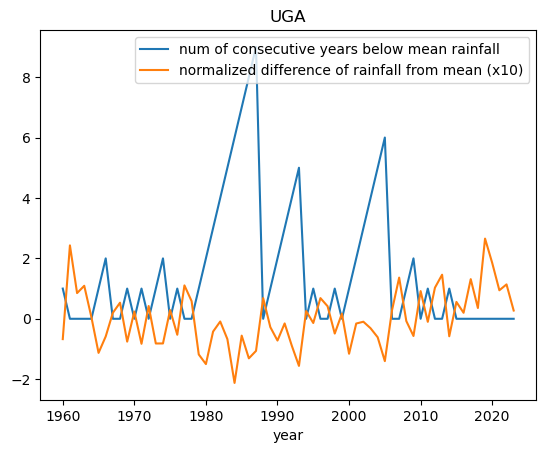

In [89]:
plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].n_below_rainfall,
         label='num of consecutive years below mean rainfall')

plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].rainfall_diff_from_mean_norm*10,
         label='normalized difference of rainfall from mean (x10)')

plt.xlabel('year')
plt.legend()
plt.title('UGA')
plt.show()

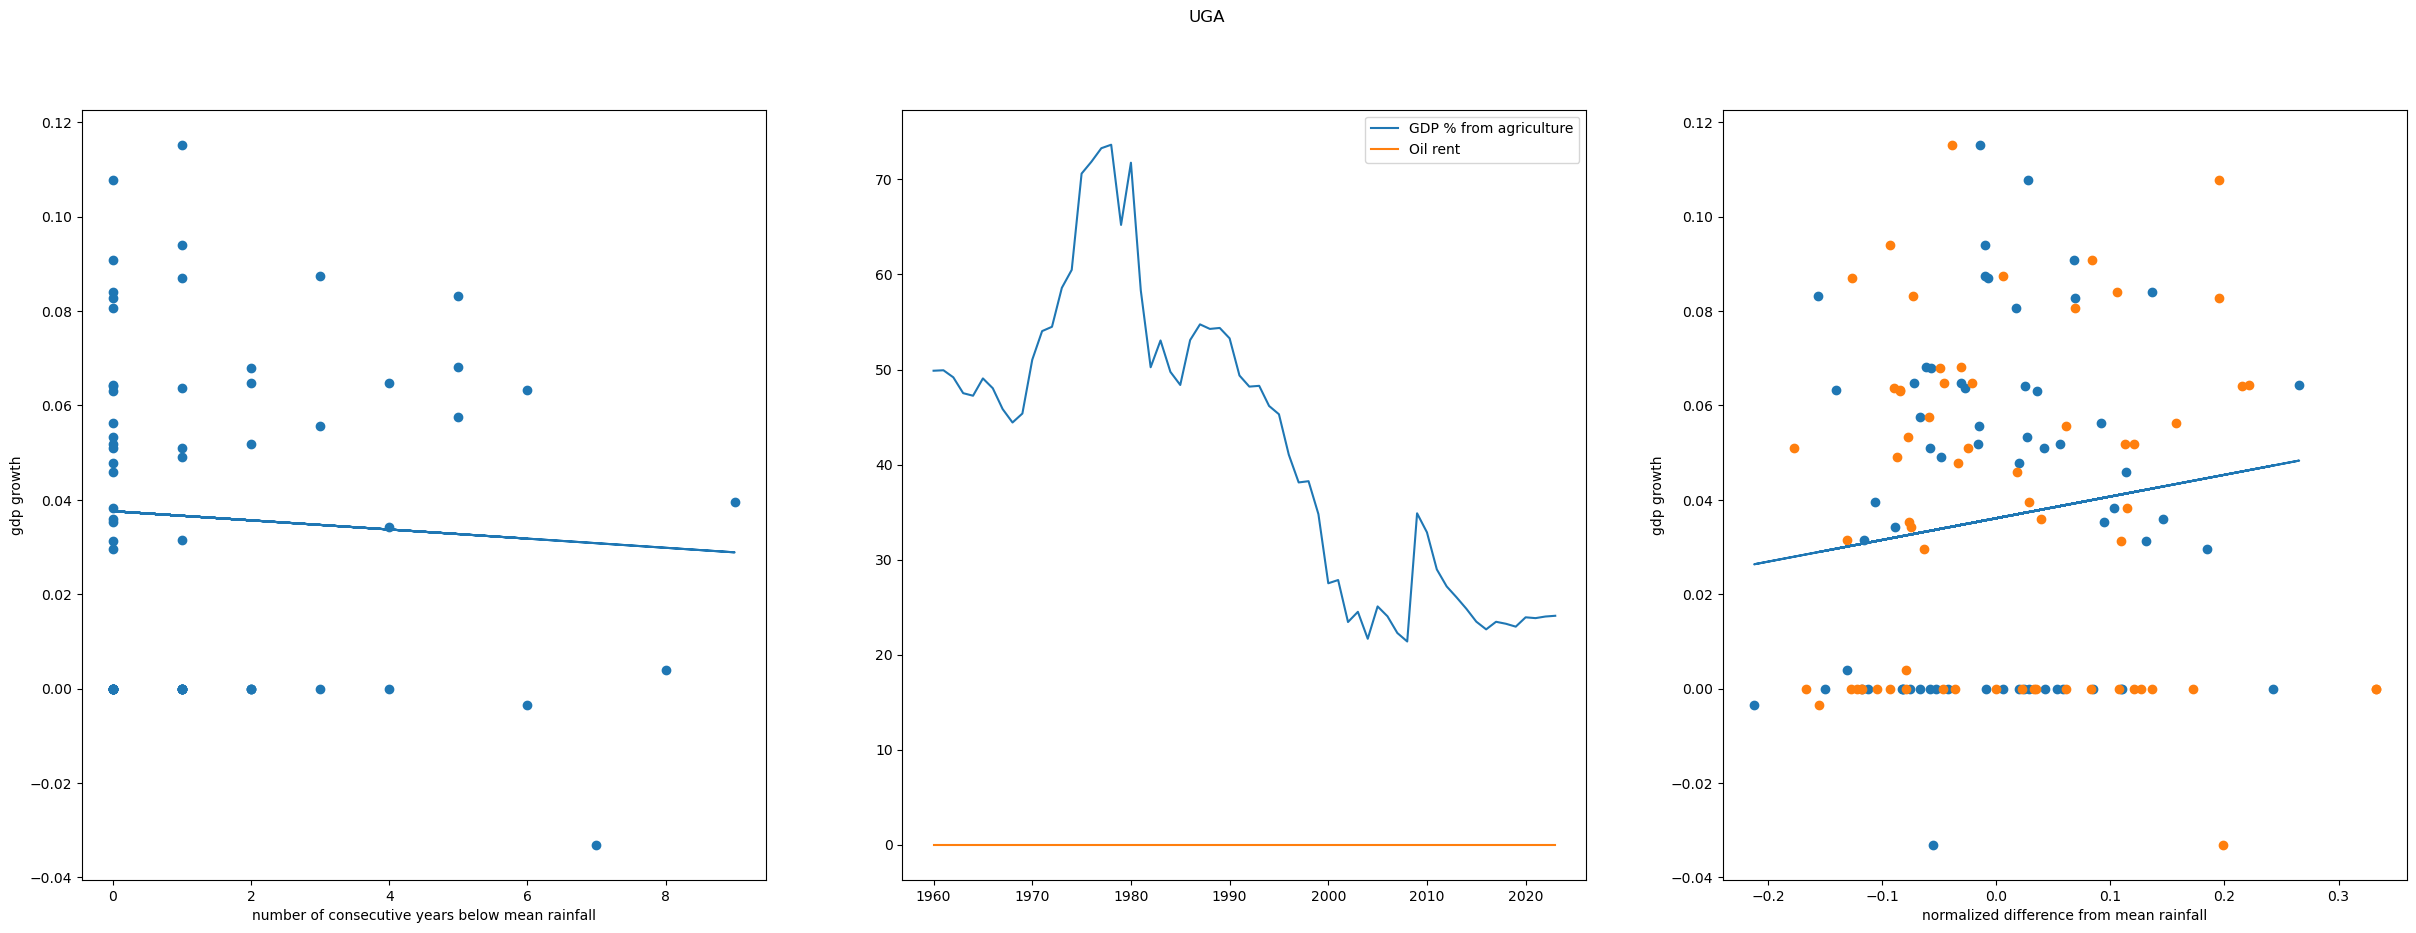

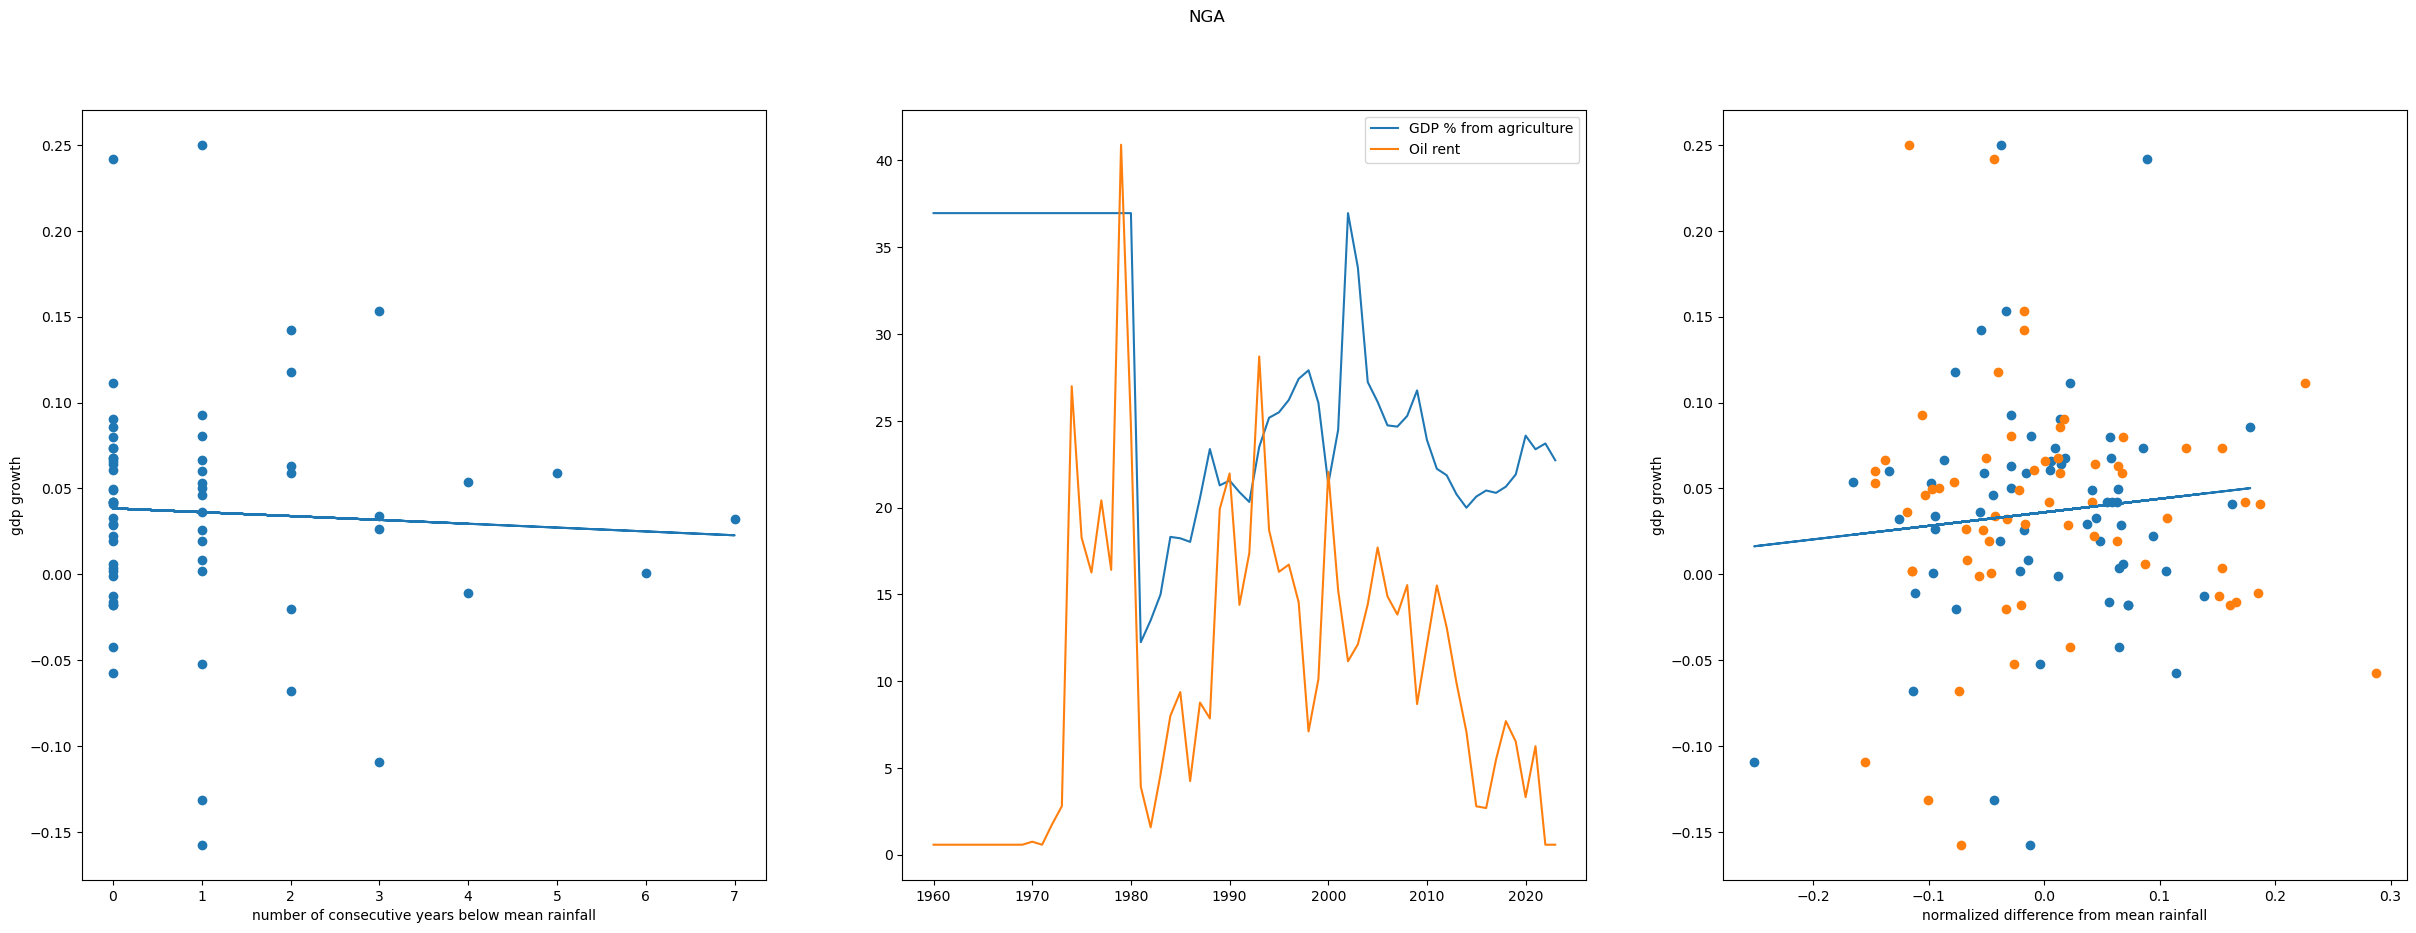

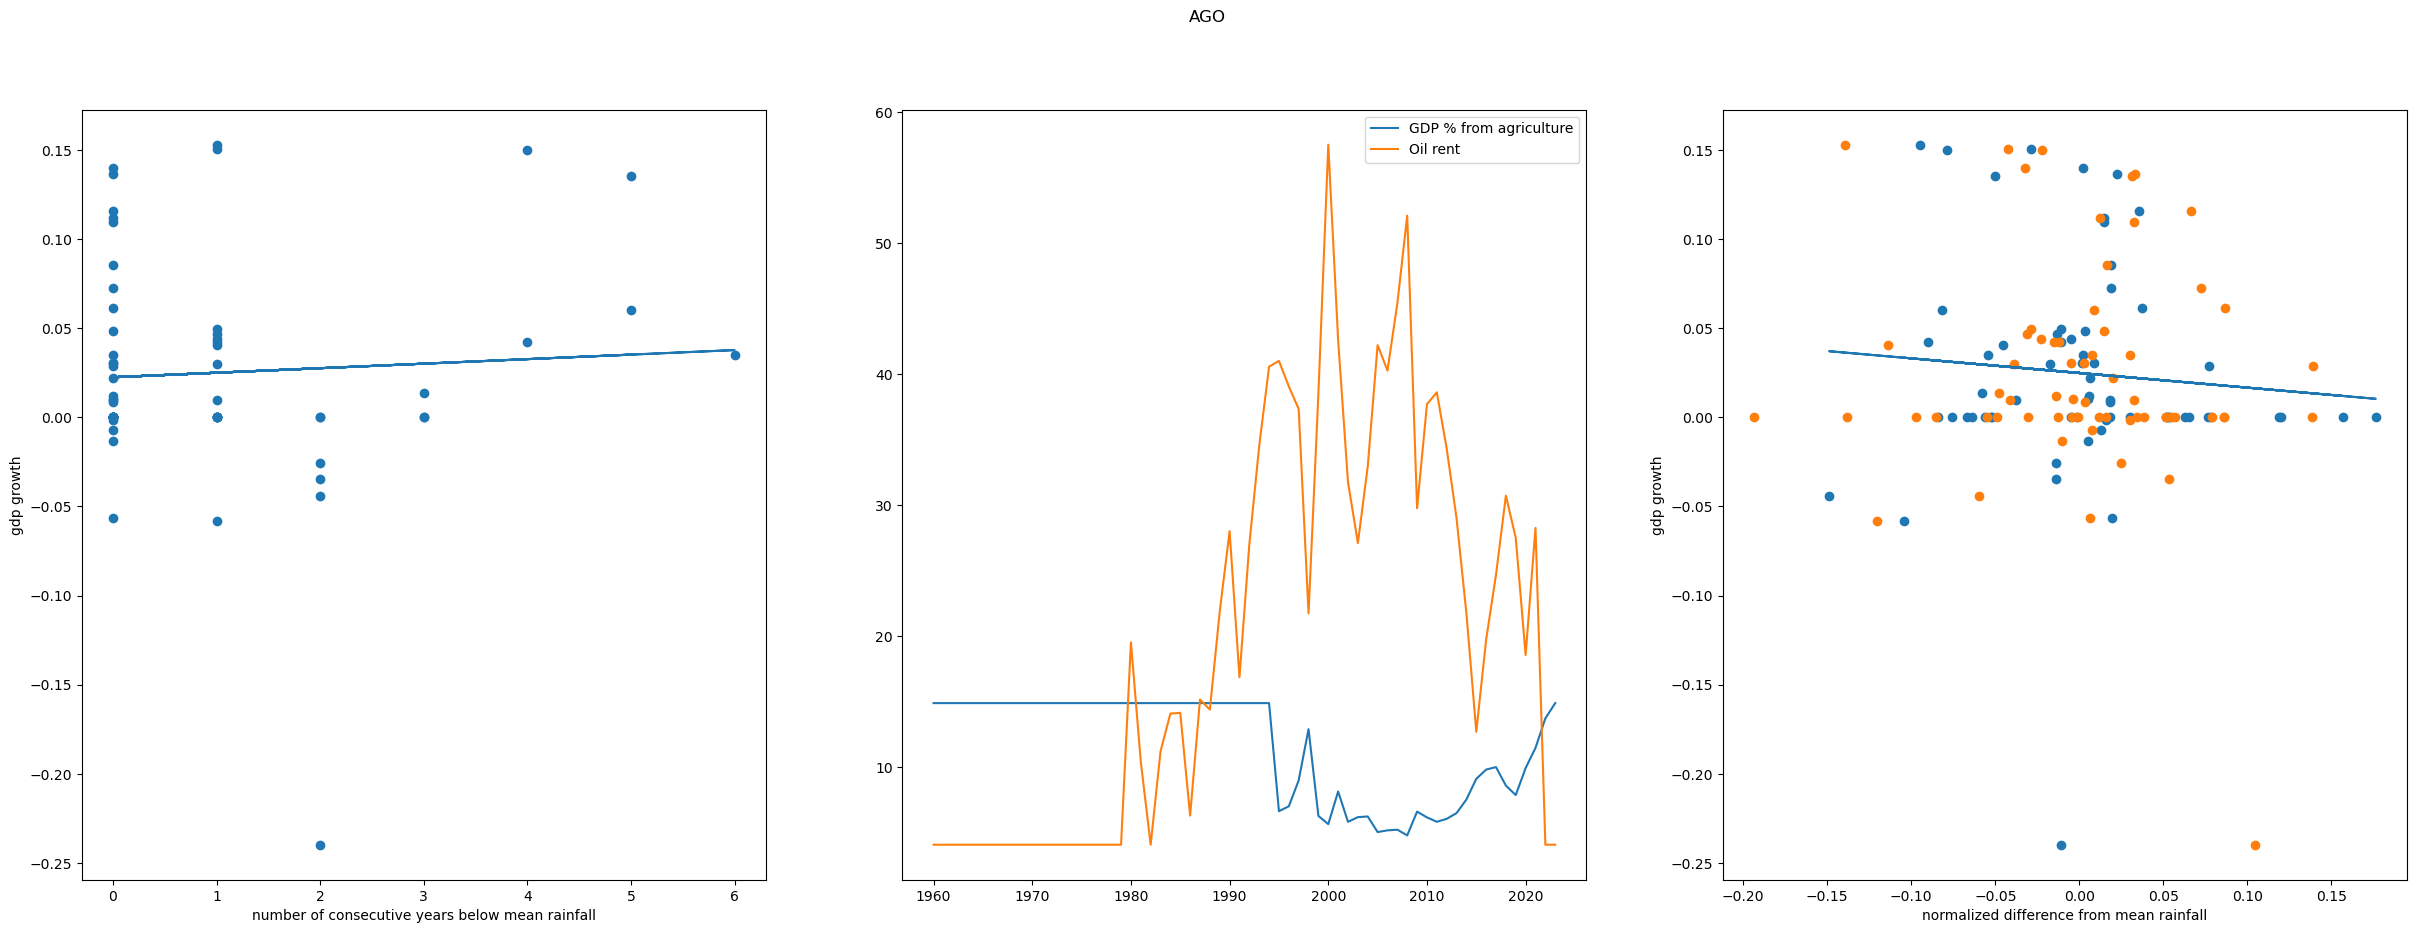

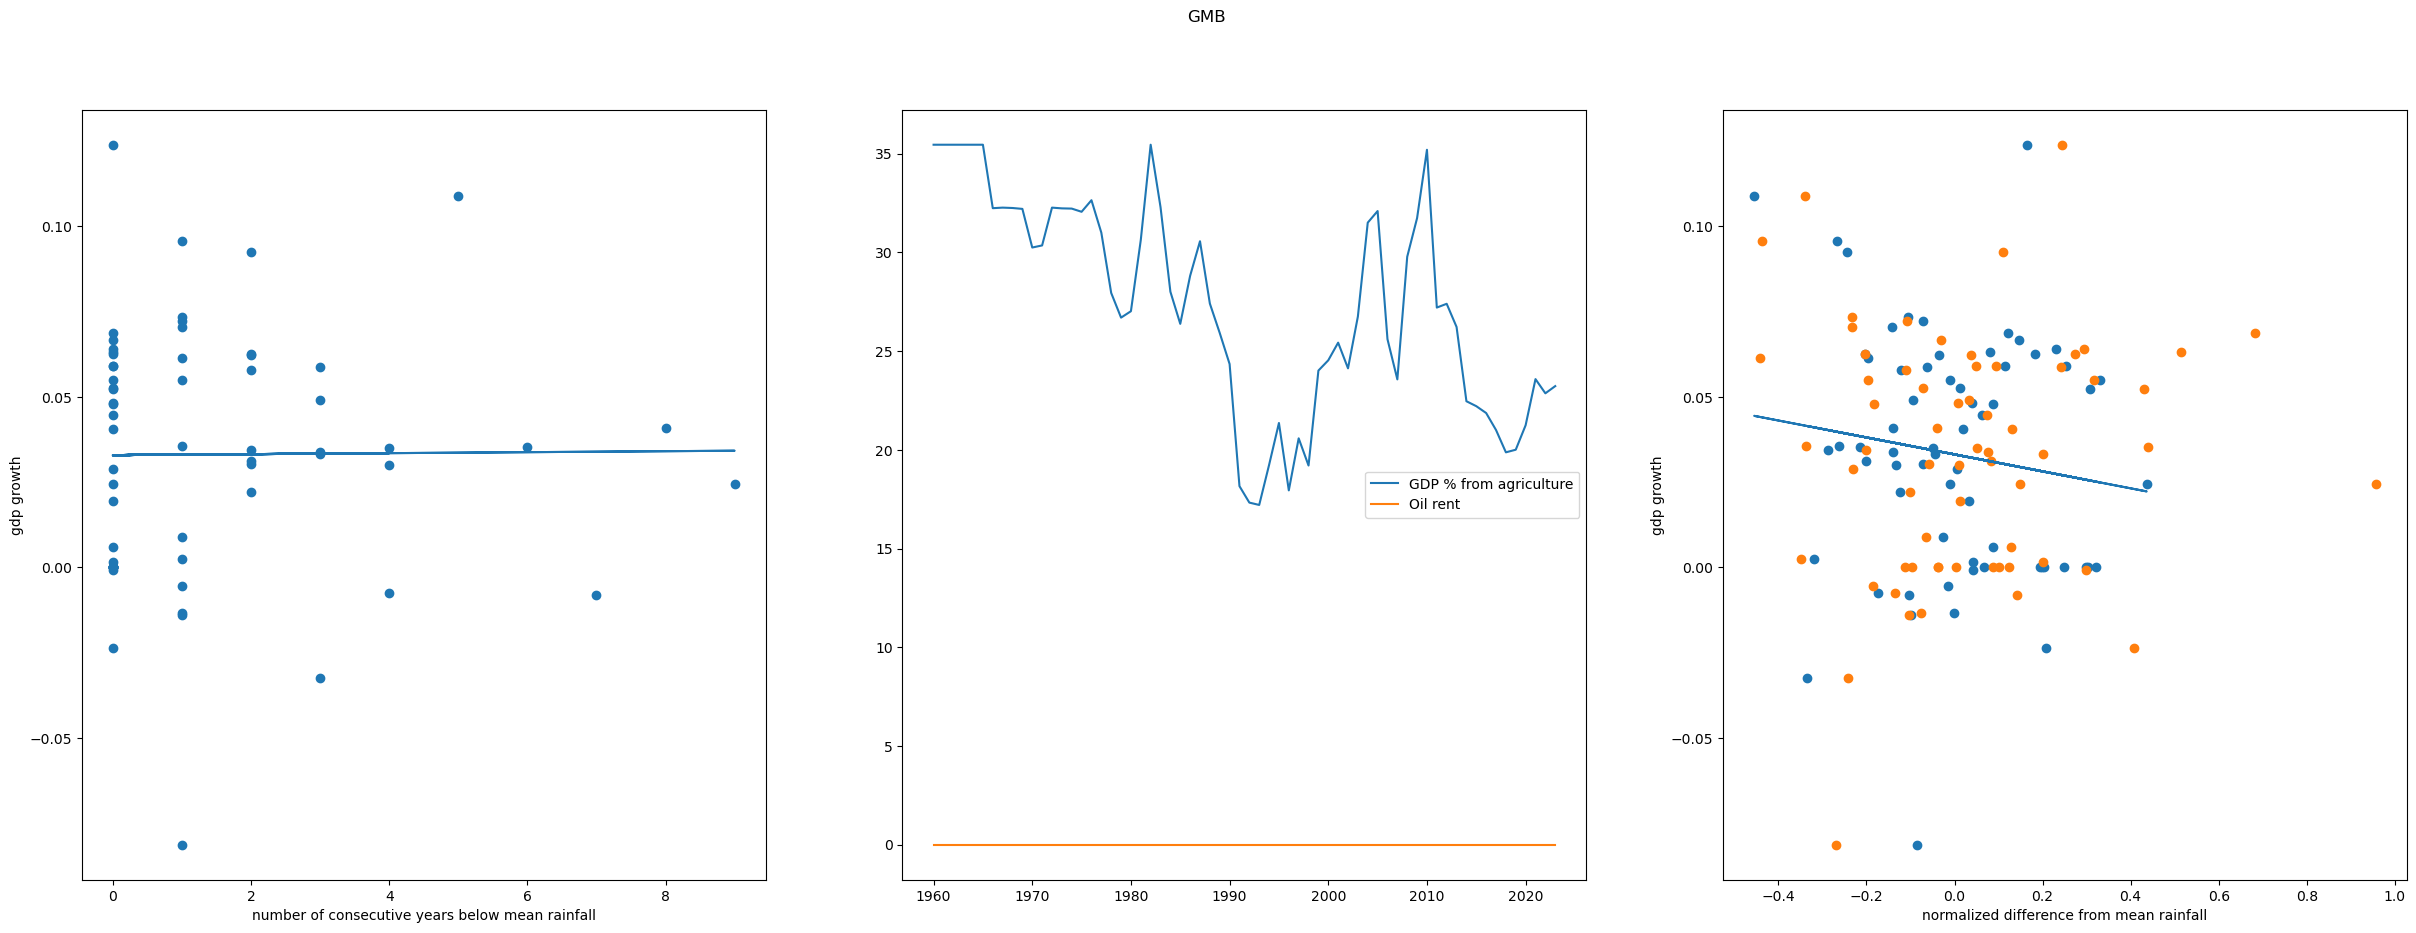

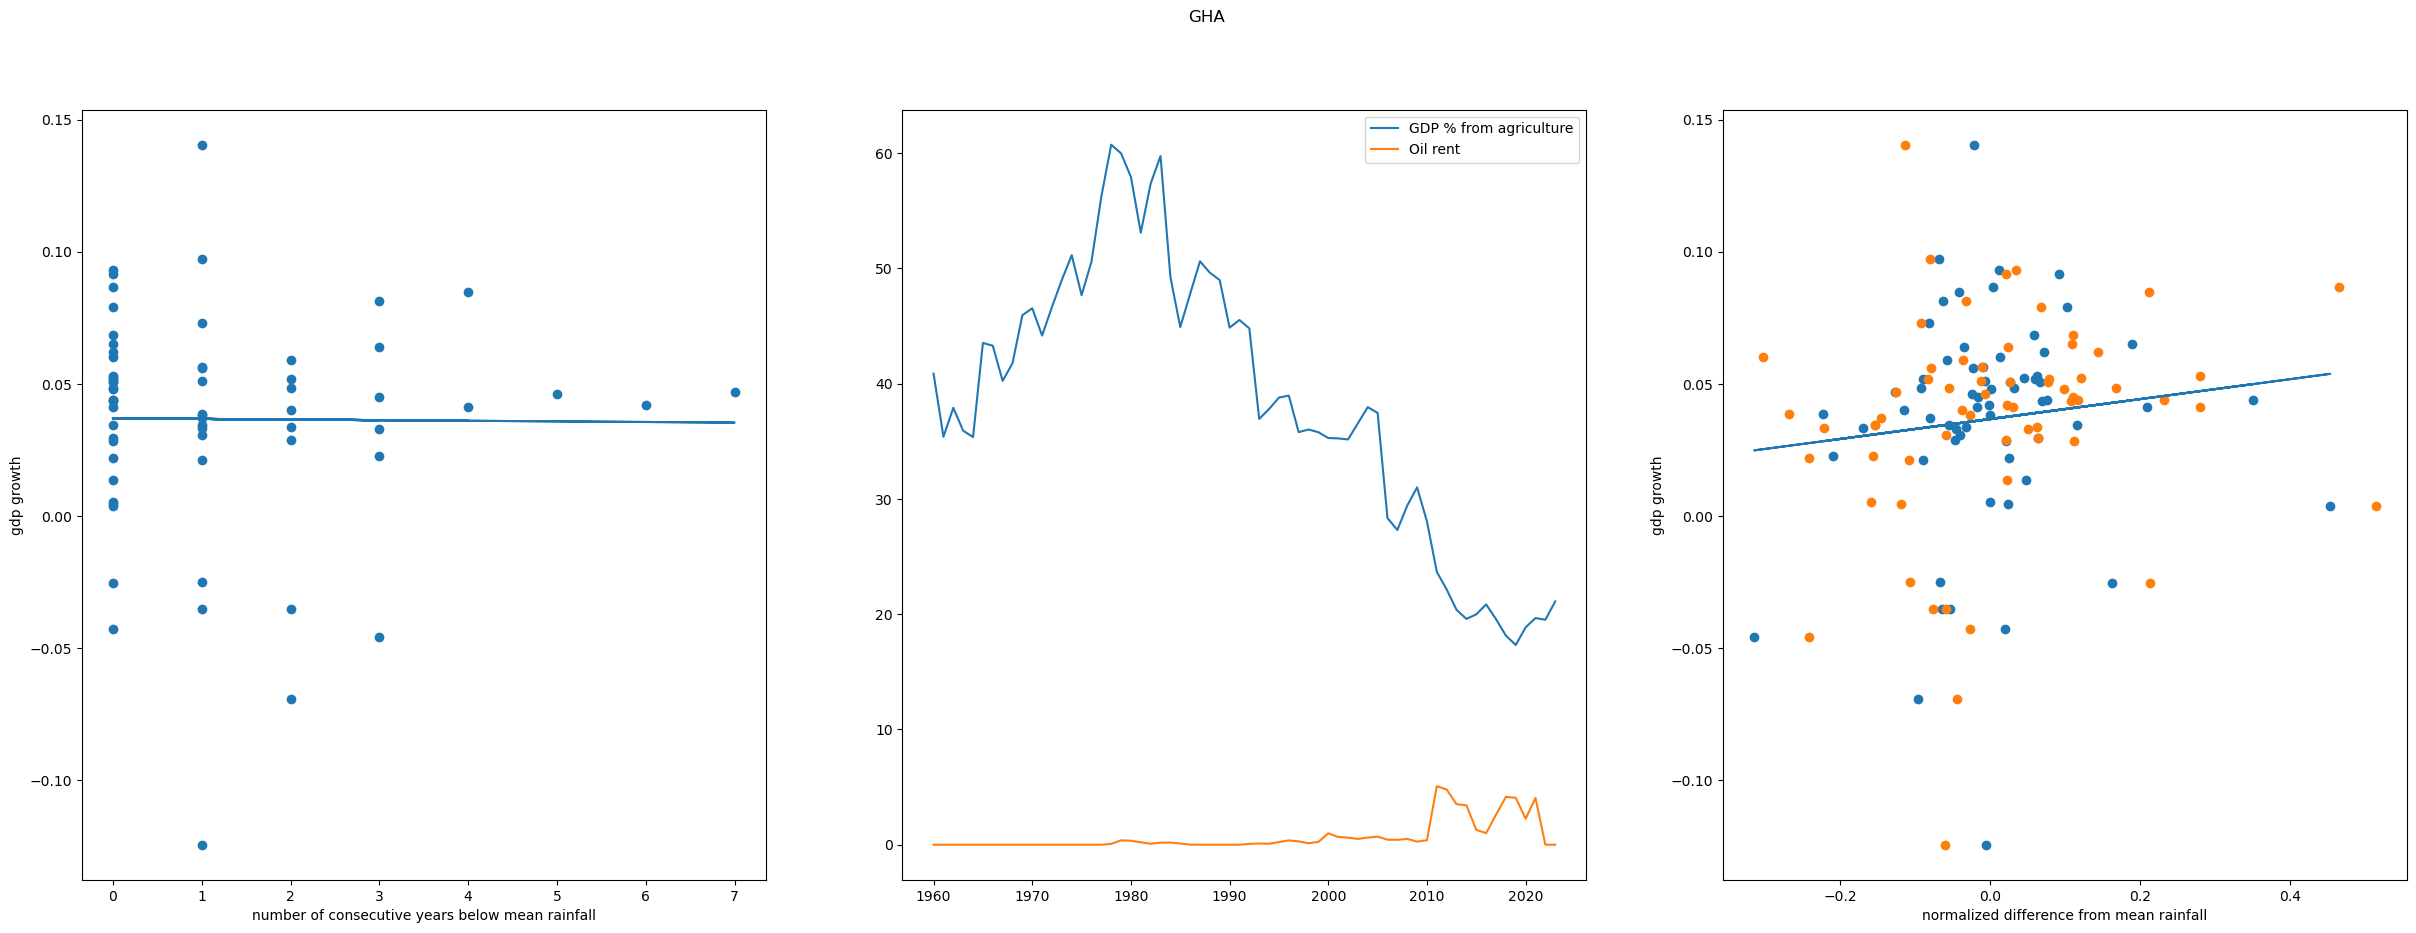

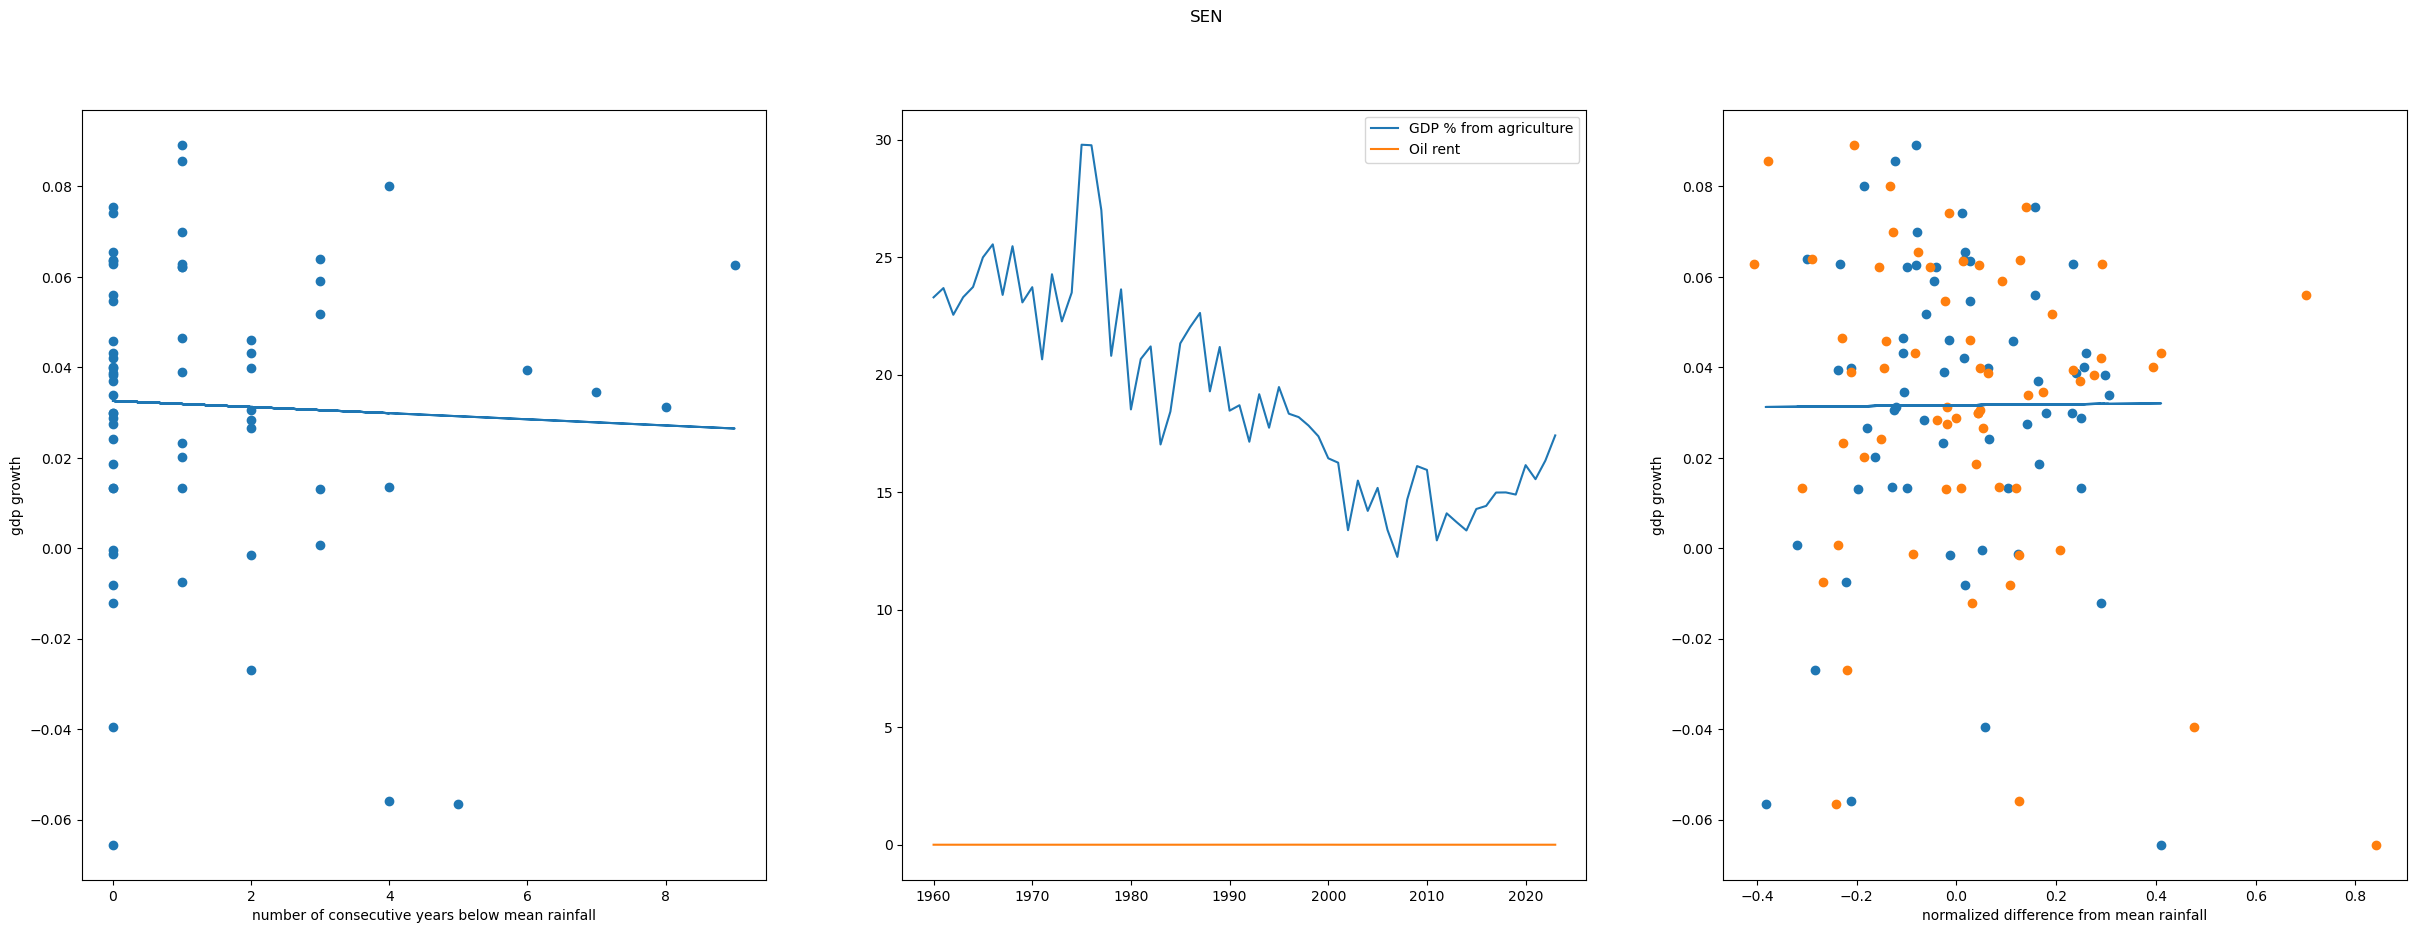

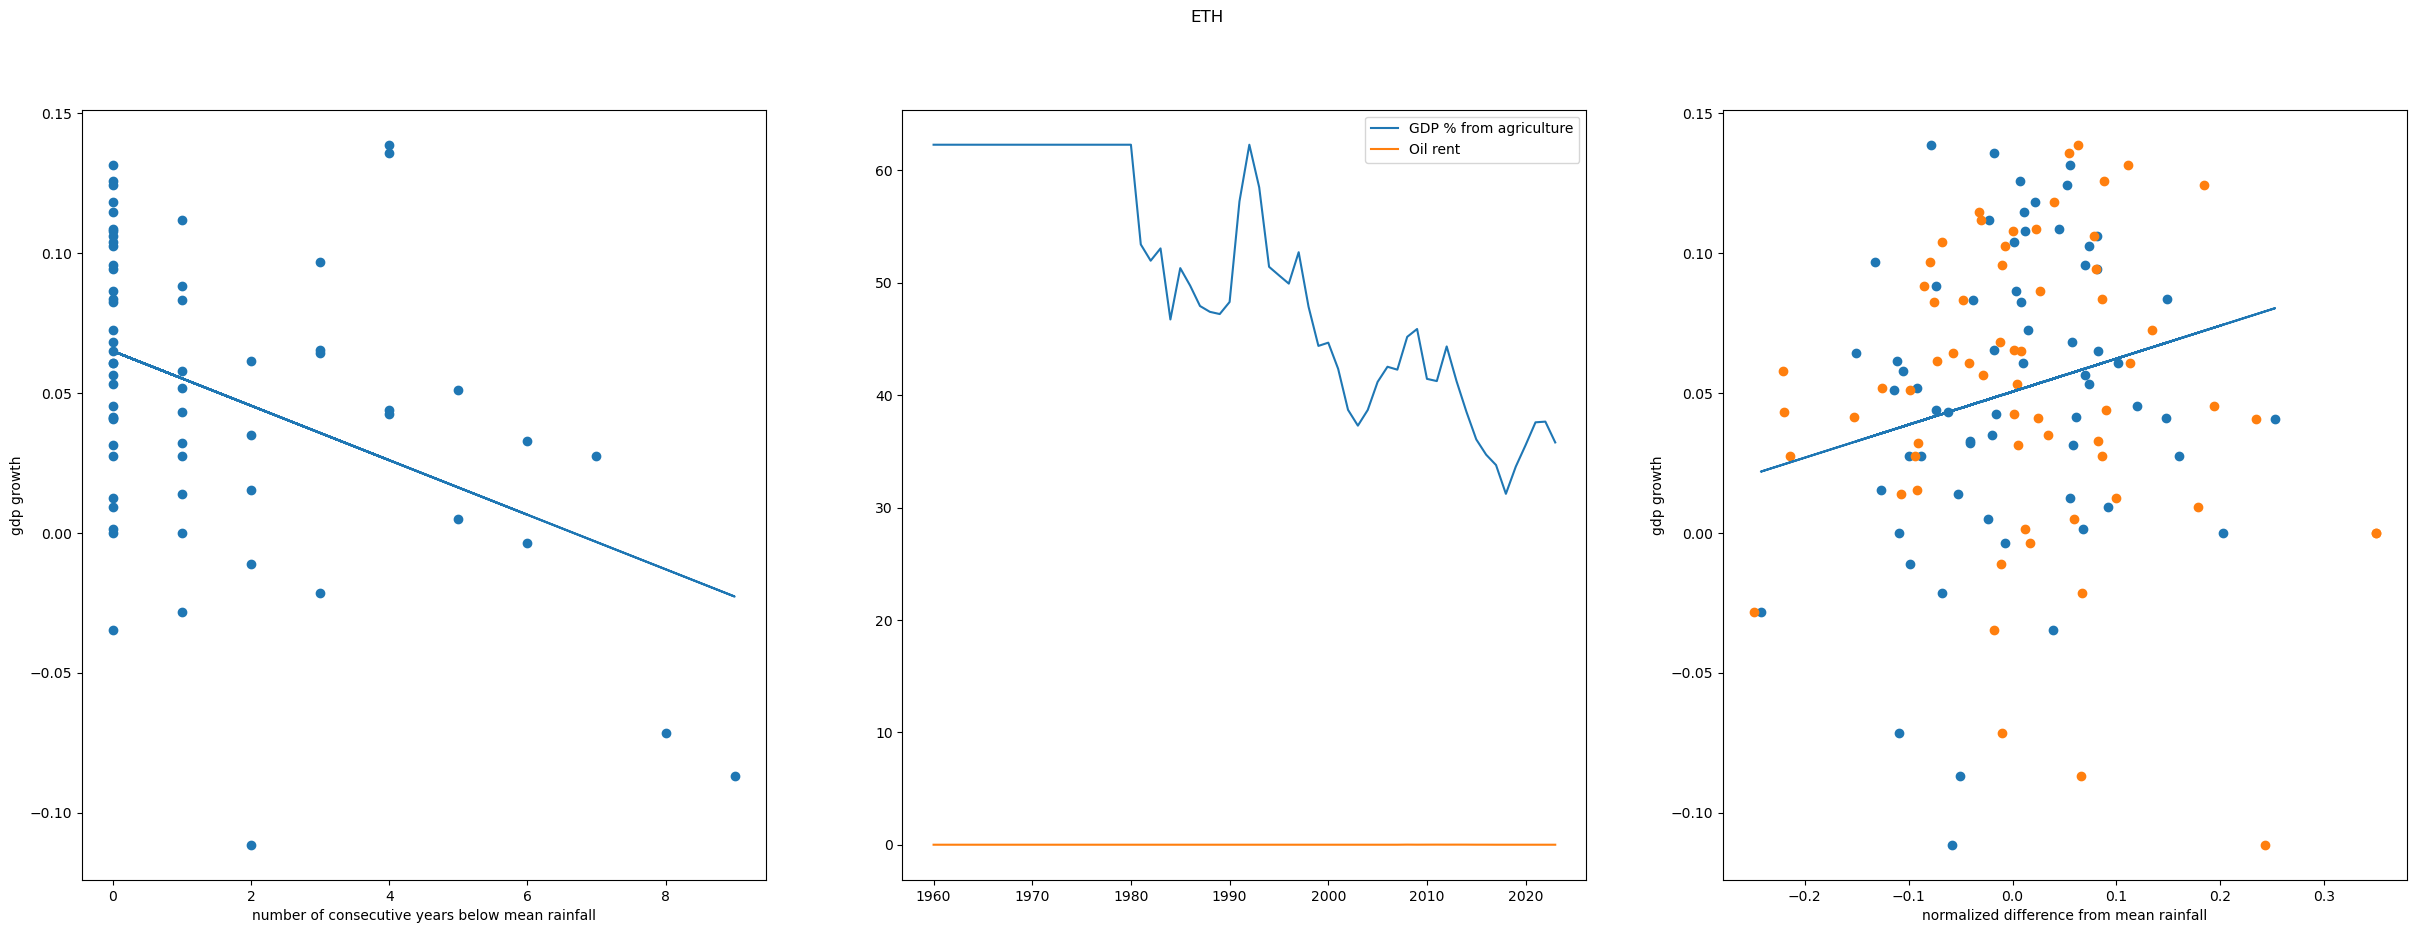

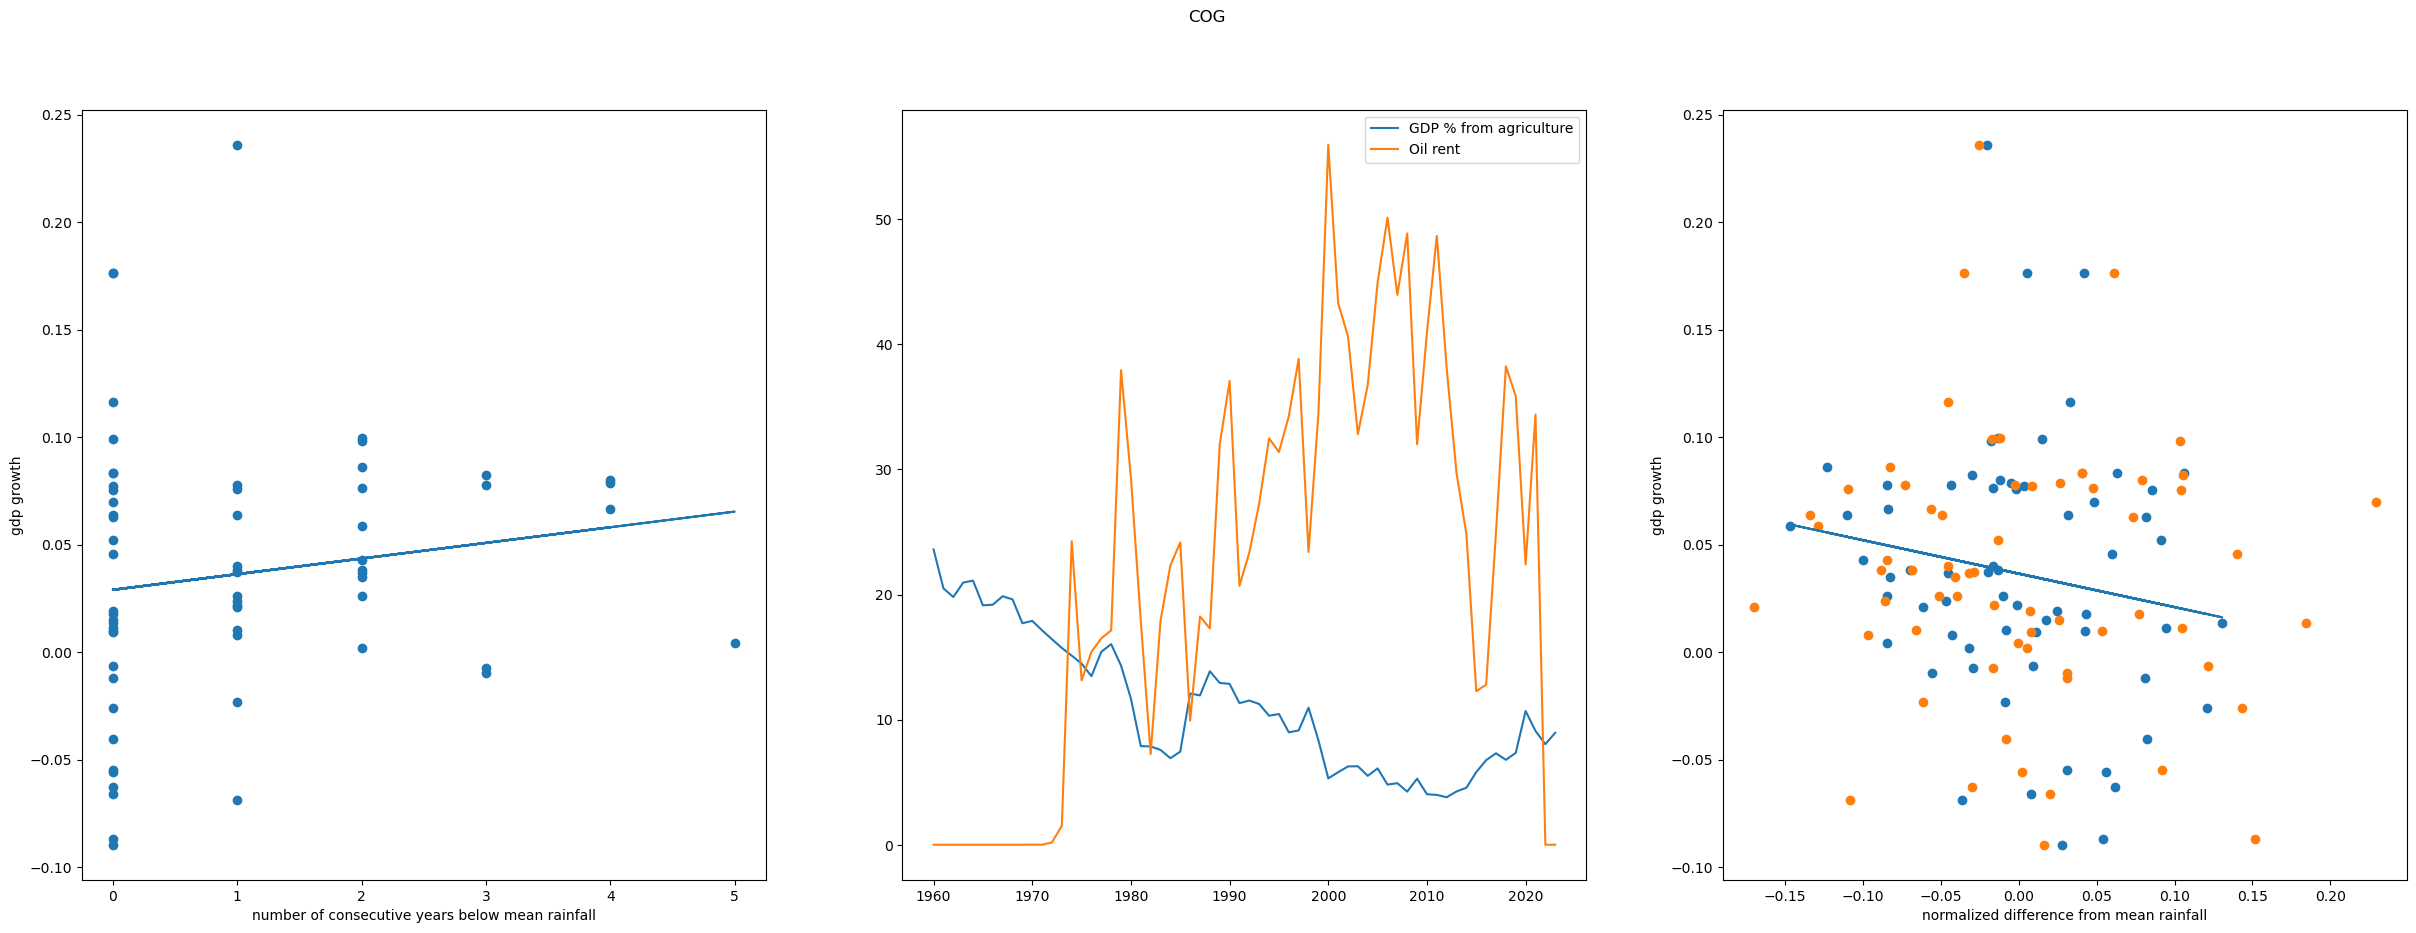

In [90]:
from sklearn.linear_model import LinearRegression

countries = ['UGA', 'NGA', 'AGO', 'GMB', 'GHA', 'SEN', 'ETH', 'COG']

for country in countries:
    fig, ax = plt.subplots(1,3,figsize=(30,10))
    country_subset = subset[subset['ISO3_code']==country]

    ax[0].scatter(country_subset['n_below_rainfall'], country_subset['gdp_g'])

    ols = LinearRegression()
    ols.fit(country_subset[['n_below_rainfall']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['n_below_rainfall']])
    ax[0].plot(country_subset['n_below_rainfall'], yp)

    ax[0].set_xlabel('number of consecutive years below mean rainfall')
    ax[0].set_ylabel('gdp growth')

    ax[1].plot(country_subset['Year'], country_subset['pt_gdp_agriculture'], label='GDP % from agriculture')
    ax[1].plot(country_subset['Year'], country_subset['oil_rent'], label='Oil rent')
    ax[1].legend()

    ax[2].scatter(country_subset['rainfall_diff_from_mean_norm'], country_subset['gdp_g'])
    ols.fit(country_subset[['rainfall_diff_from_mean_norm']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['rainfall_diff_from_mean_norm']])
    ax[2].plot(country_subset['rainfall_diff_from_mean_norm'], yp)
    ax[2].set_xlabel('normalized difference from mean rainfall')
    ax[2].set_ylabel('gdp growth')

    ax[2].scatter(country_subset['rainfall_var_t'], country_subset['gdp_g'])

    plt.suptitle(country)
    plt.show()


## Try OLS on countries with low oil production and high agricultural output


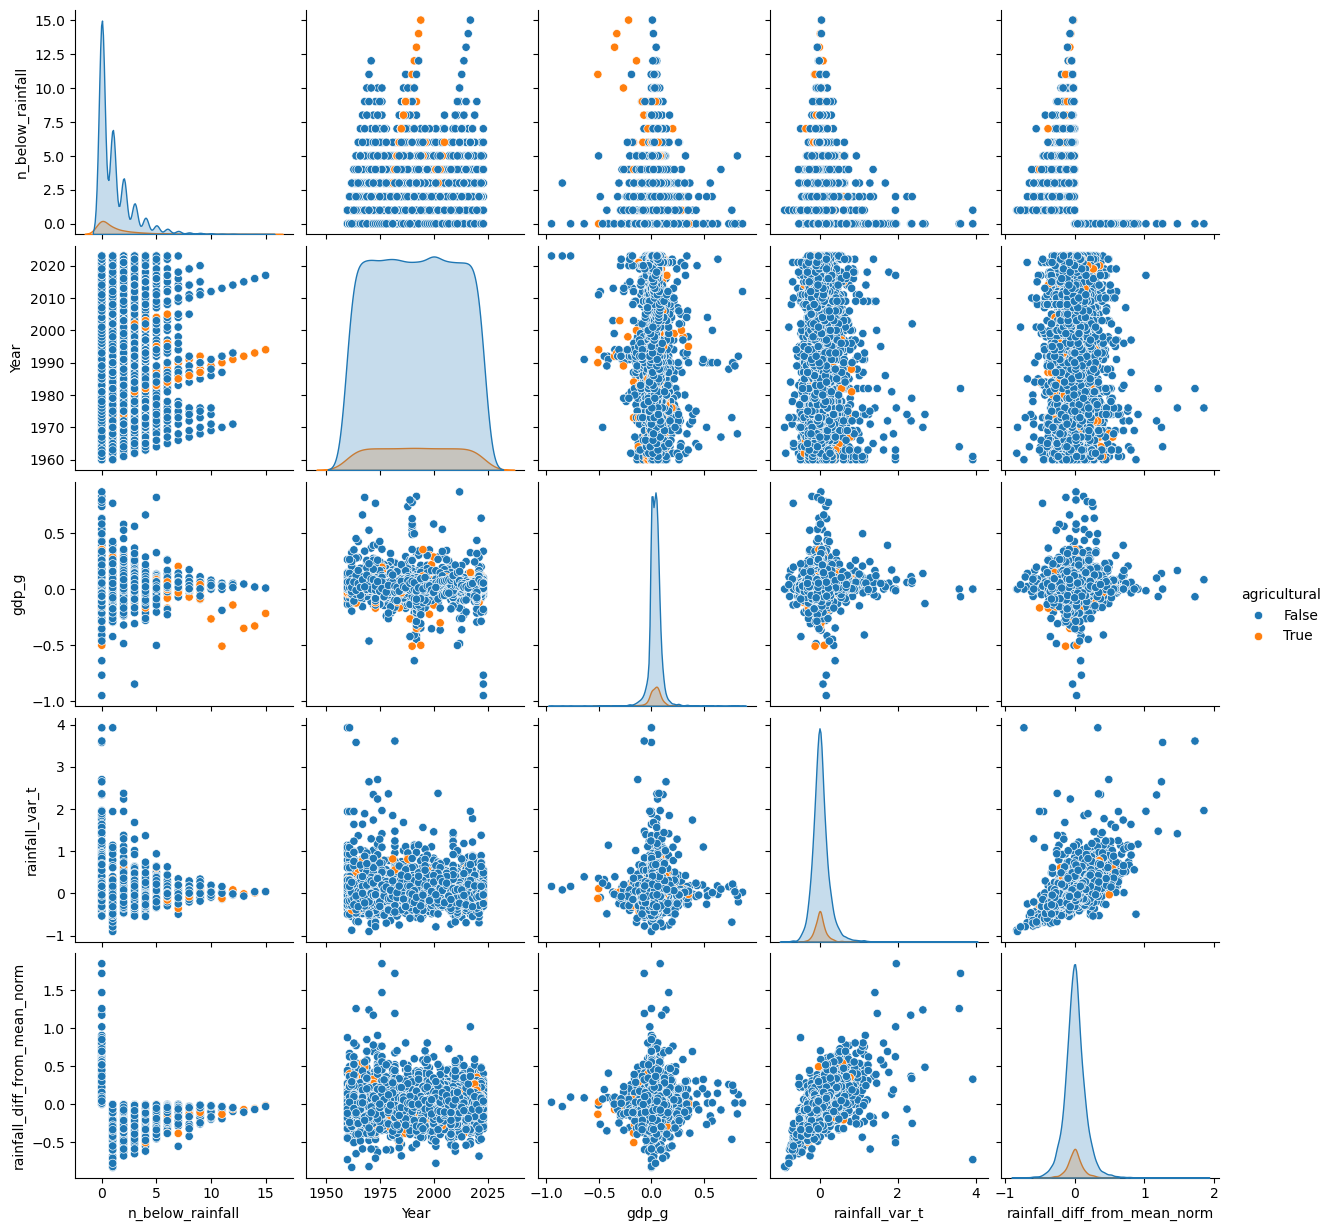

In [79]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='agricultural')

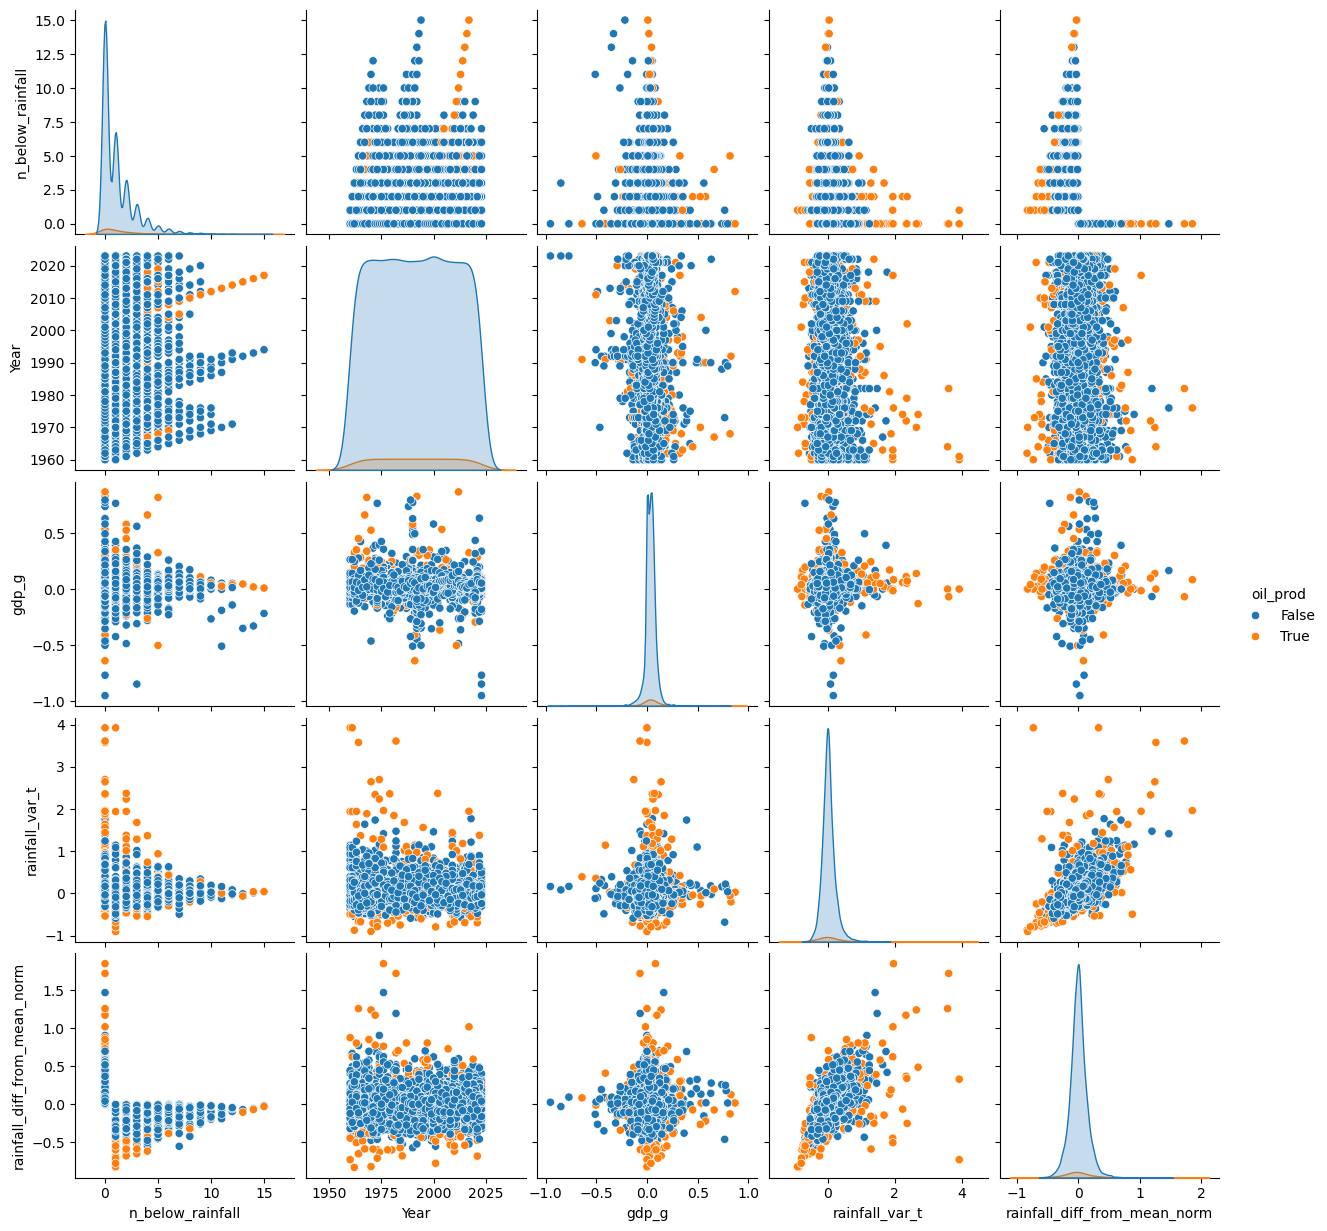

In [80]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='oil_prod')

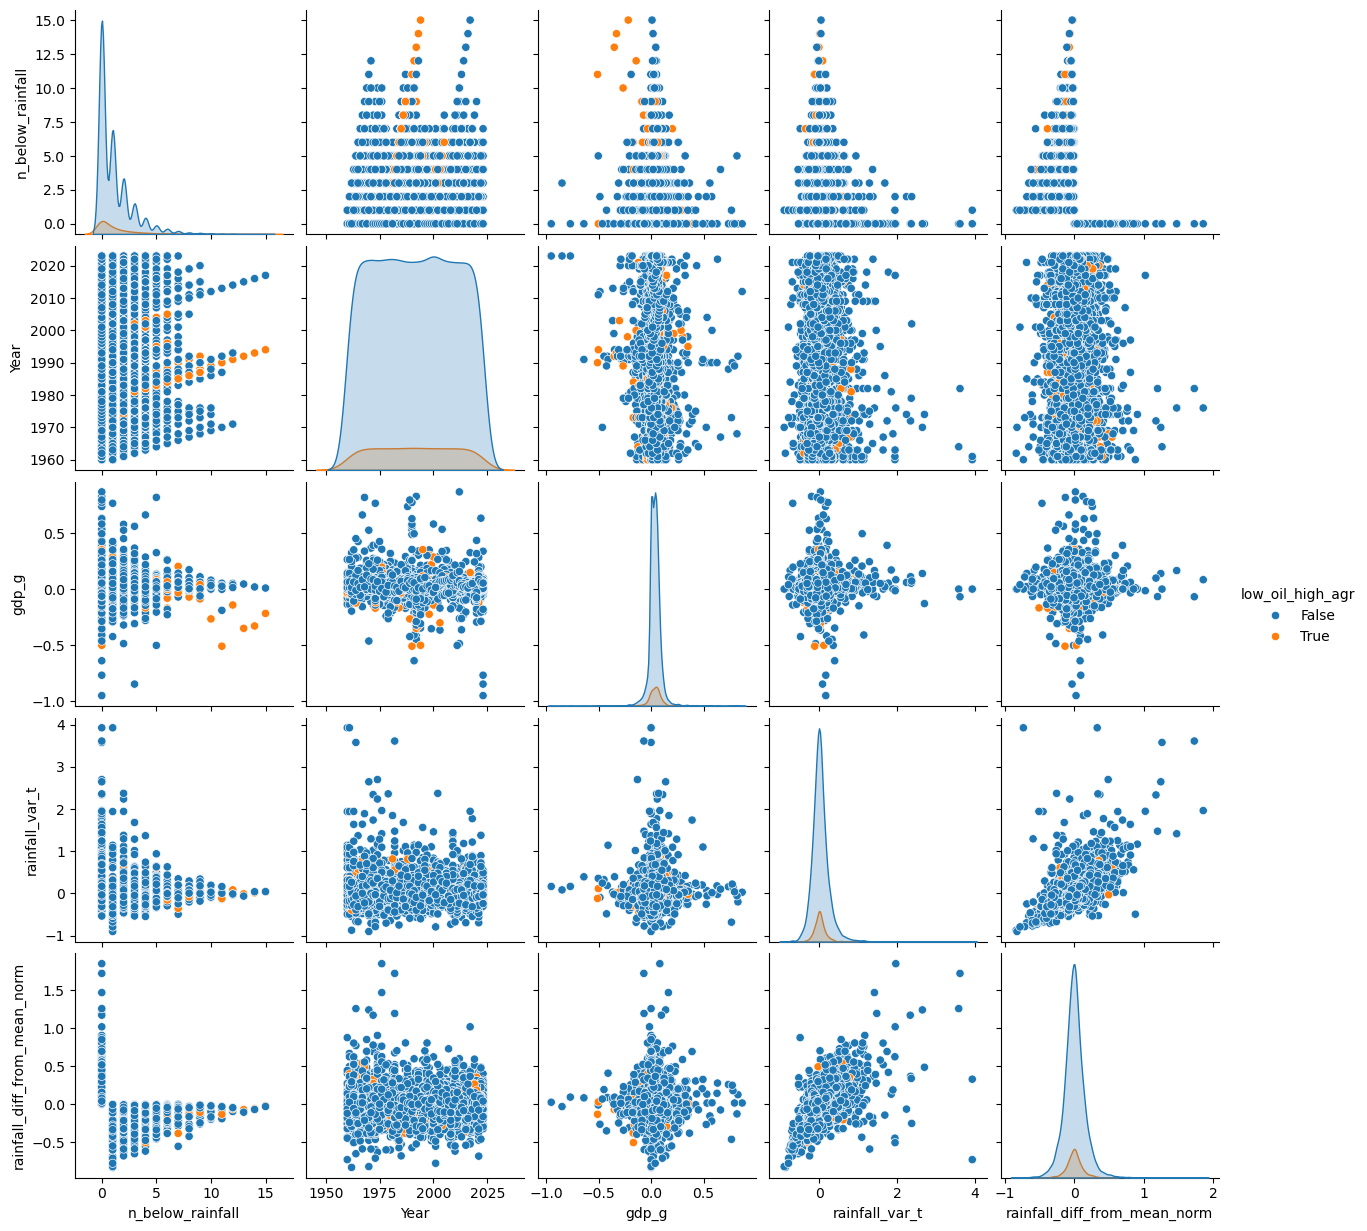

In [91]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='low_oil_high_agr')

In [62]:
low_oil_high_agriculture = subset[(subset['oil_prod']==False) & (subset['agricultural']==True)]

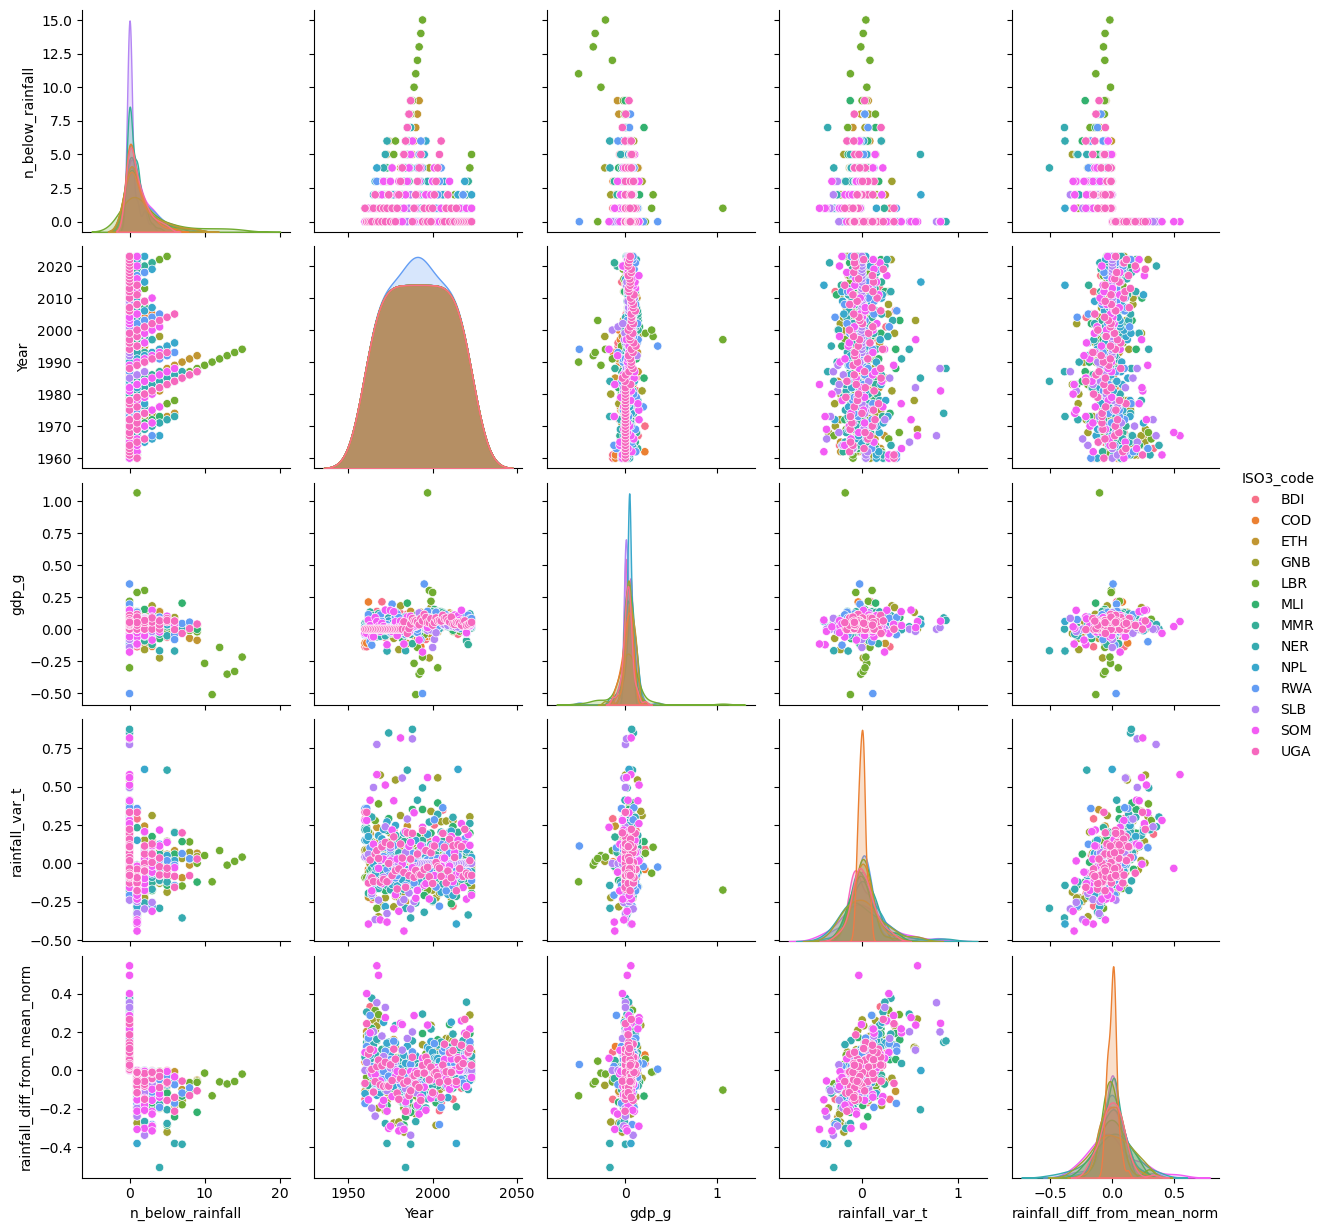

In [69]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'ISO3_code']

sns.pairplot(low_oil_high_agriculture[plot_feats], hue='ISO3_code')

In [63]:
from sklearn.metrics import root_mean_squared_error

feat = ['n_below_rainfall']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0685, rmse:0.07303


In [64]:
feat = ['rainfall_diff_from_mean_norm']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0086, rmse:0.07534


In [65]:
feat = ['rainfall_var_t']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0008, rmse:0.07564
